<a href="https://colab.research.google.com/github/manvendra-07/DL-Lab/blob/main/Week%206/200968146_DL_Week6_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the required libraries

In [15]:
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

## Preparing the dataset

- **Importing the dataset**

In [16]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header = None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


- **Creating column names for the data**

In [17]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,area_type_1,soil_type_29,4
1,2590,56,2,212,-6,390,220,235,151,6225,area_type_1,soil_type_29,4
2,2804,139,9,268,65,3180,234,238,135,6121,area_type_1,soil_type_12,1
3,2785,155,18,242,118,3090,238,238,122,6211,area_type_1,soil_type_30,1
4,2595,45,2,153,-1,391,220,234,150,6172,area_type_1,soil_type_29,4


- **Splitting the data into train and test sets**

In [18]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 494112
Test split size: 86900


- **Storing the test and train data in their respective csv files**

In [19]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

- **Creating meta information about the data**

In [20]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

- **Defining an input function that reads and parses the file, then converts features and labels into atf.data.Dataset for evaluation**

In [21]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

## Defining function for running model testing and evaluation and setting the hyper-parameters

In [22]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

## Function to create the inputs to be fed to the models


In [23]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

## Creating two representations of our input features : Sparse and Dense
- **Sparse Representation, the categorical features are encoded with one-hot encoding**

- **Dense Representation, the categorical features are encoded with low-dimensional embeddings**

In [24]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

## Creating the  Multi-Layer Feed-Forward Network

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


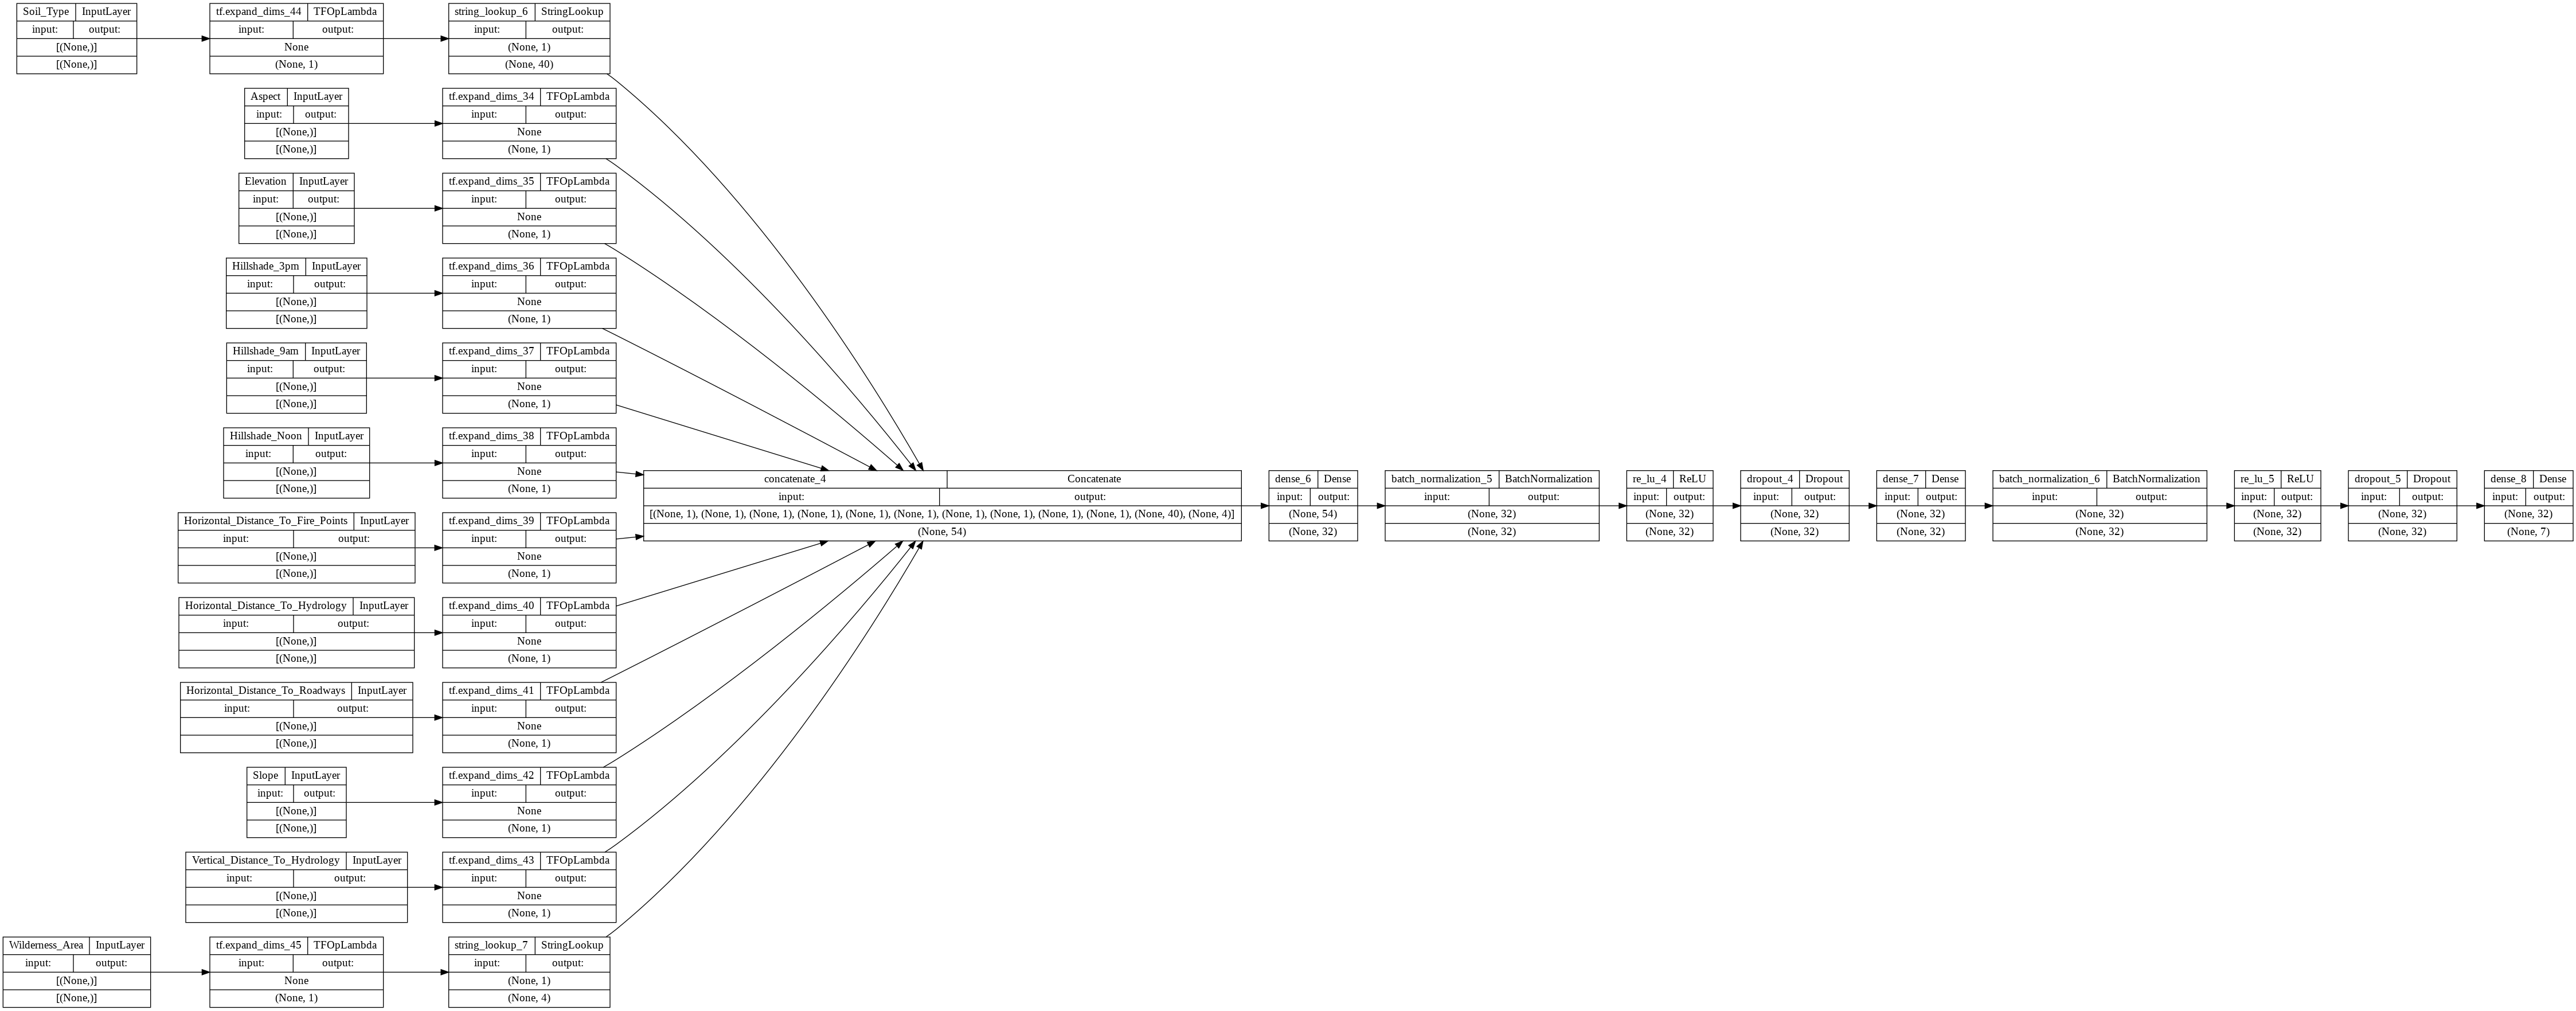

In [25]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

- **Training and Testing the model**

In [26]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 14s 7ms/step - loss: 0.8111 - sparse_categorical_accuracy: 0.6659
Epoch 2/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.7131
Epoch 3/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.7243
Epoch 4/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.6182 - sparse_categorical_accuracy: 0.7344
Epoch 5/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.6017 - sparse_categorical_accuracy: 0.7420
Epoch 6/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5930 - sparse_categorical_accuracy: 0.7452
Epoch 7/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5884 - sparse_categorical_accuracy: 0.7477
Epoch 8/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5815 - sparse_categorical_accuracy: 0.7504
Epo

## Creating a Wide & Deep Model

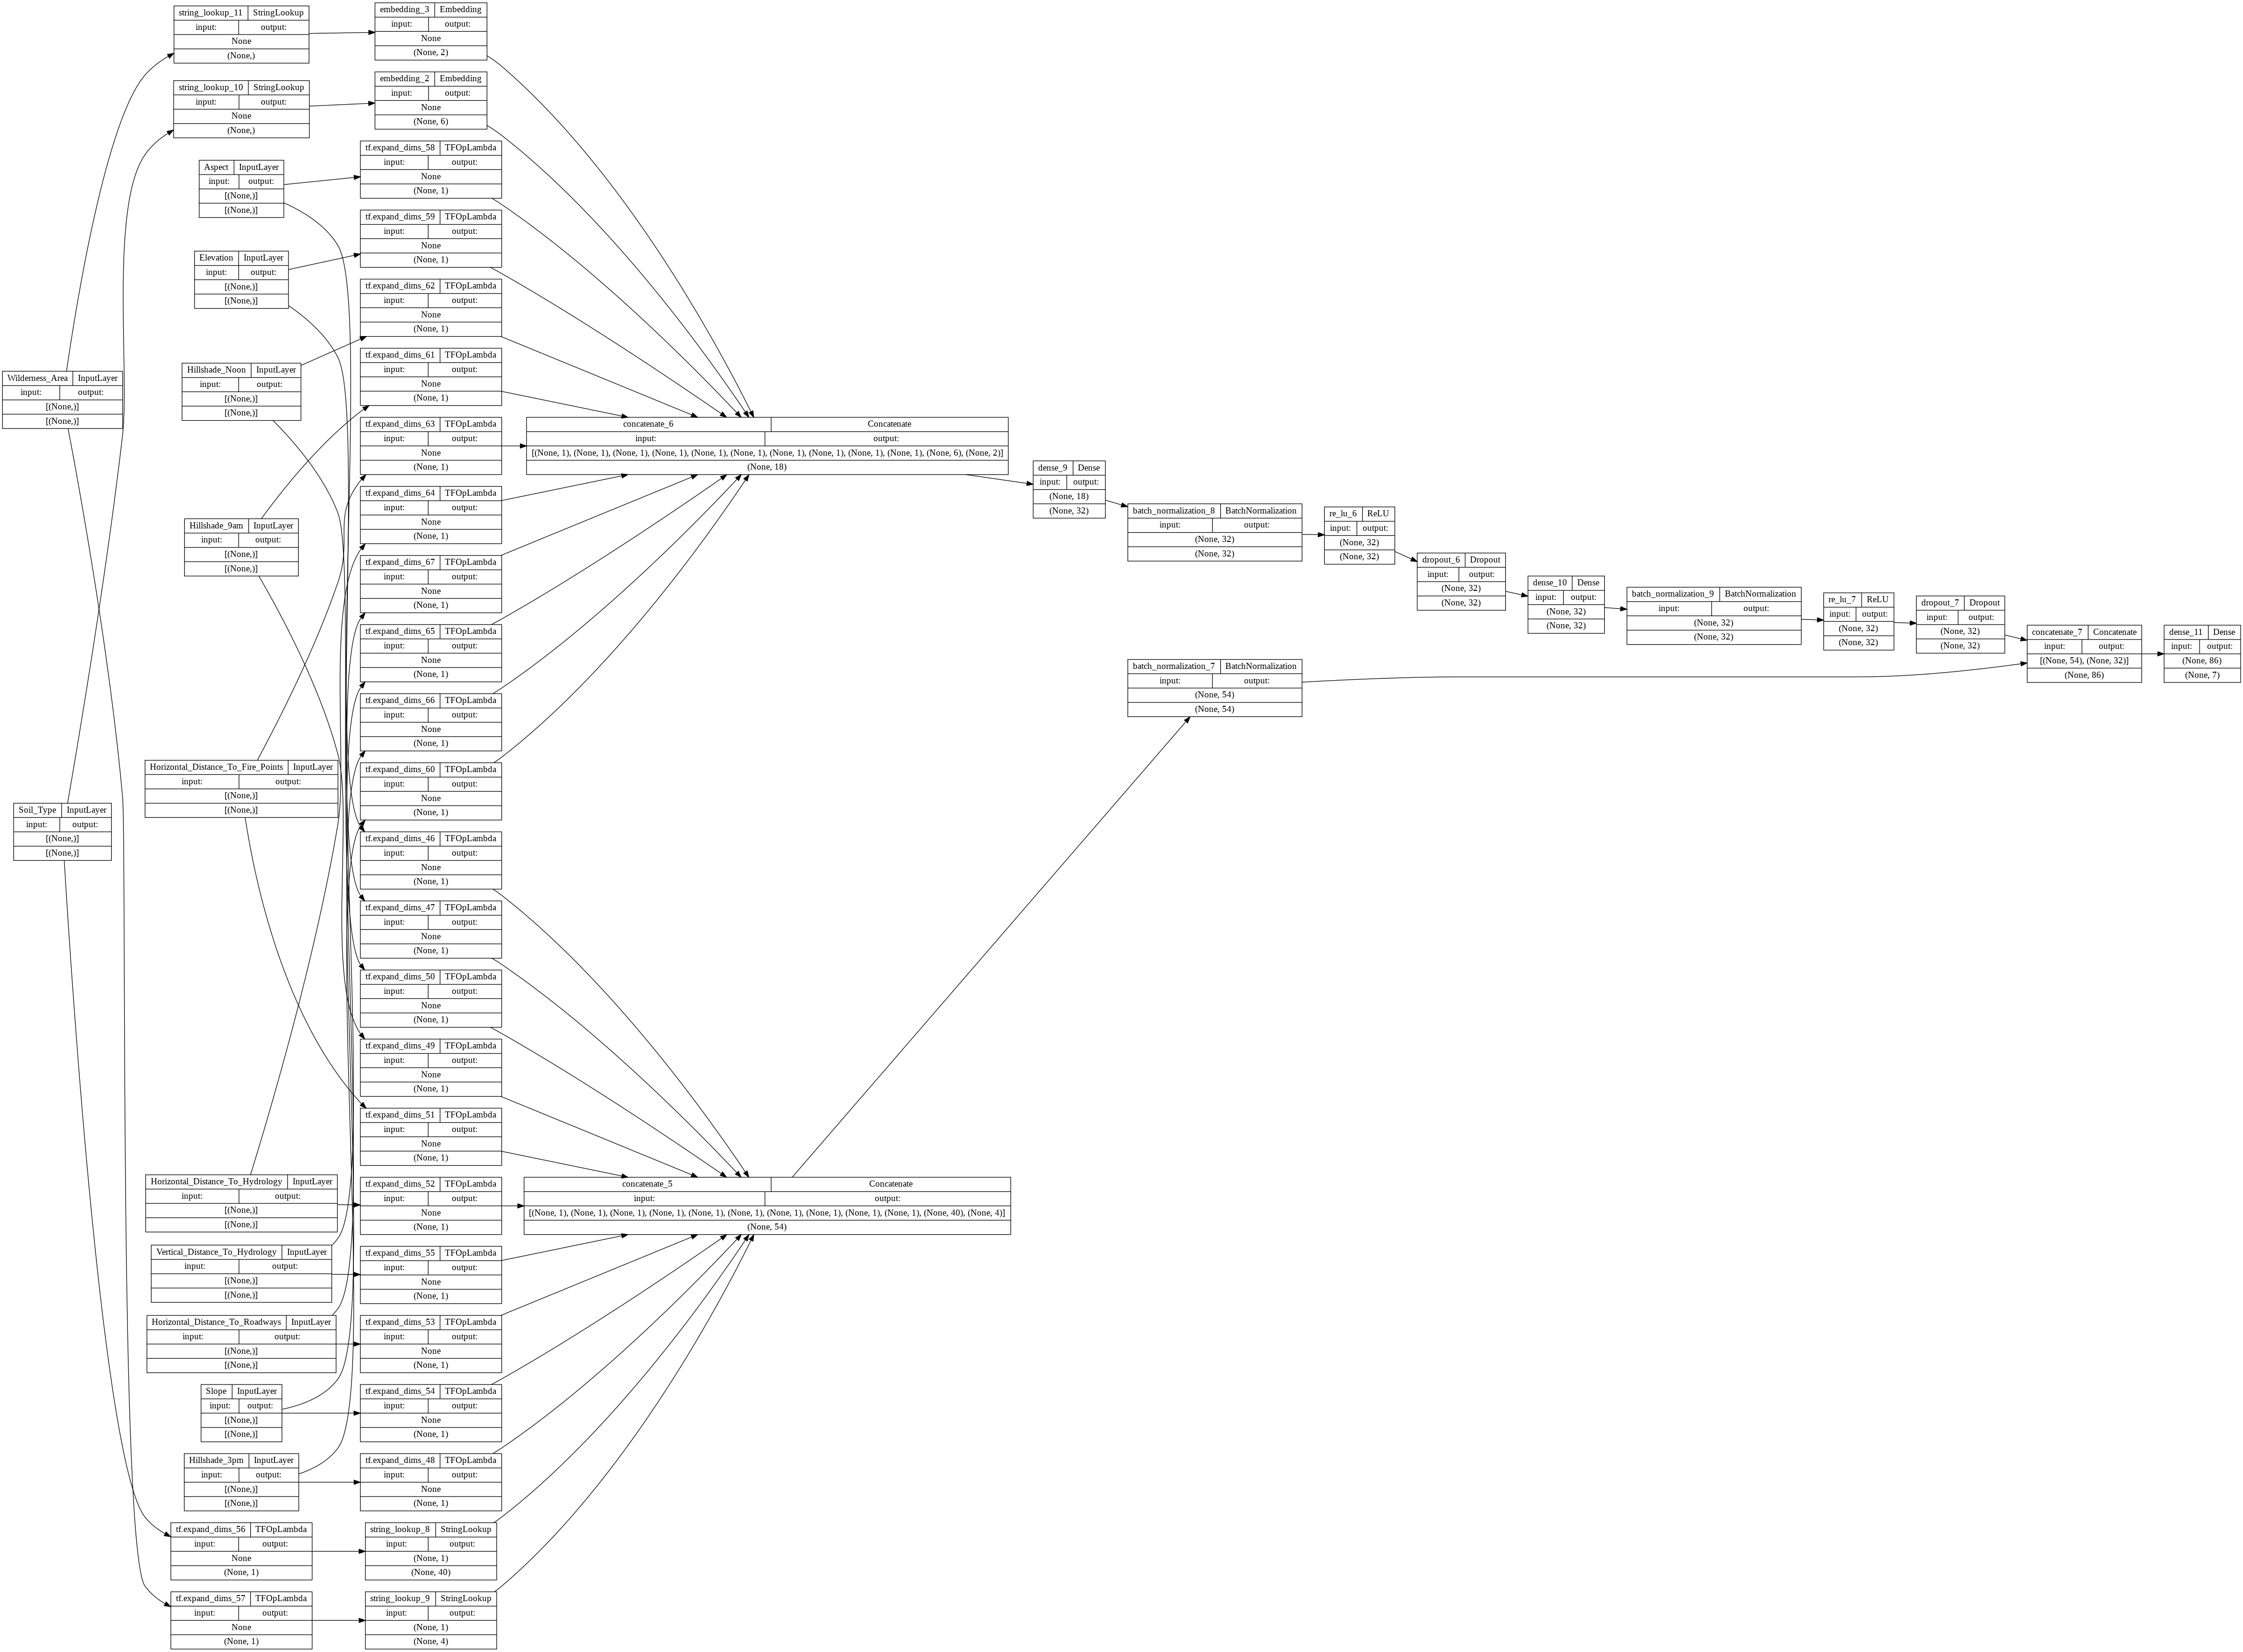

In [27]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

- **Training and Testing the model**

In [28]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 17s 9ms/step - loss: 0.7016 - sparse_categorical_accuracy: 0.7061
Epoch 2/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6036 - sparse_categorical_accuracy: 0.7374
Epoch 3/50
1865/1865 [==============================] - 12s 6ms/step - loss: 0.5874 - sparse_categorical_accuracy: 0.7437
Epoch 4/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5767 - sparse_categorical_accuracy: 0.7484
Epoch 5/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5689 - sparse_categorical_accuracy: 0.7531
Epoch 6/50
1865/1865 [==============================] - 12s 6ms/step - loss: 0.5612 - sparse_categorical_accuracy: 0.7564
Epoch 7/50
1865/1865 [==============================] - 12s 6ms/step - loss: 0.5543 - sparse_categorical_accuracy: 0.7601
Epoch 8/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5486 - sparse_categorical_accuracy: 0.7

## Creating a Deep and Cross Model

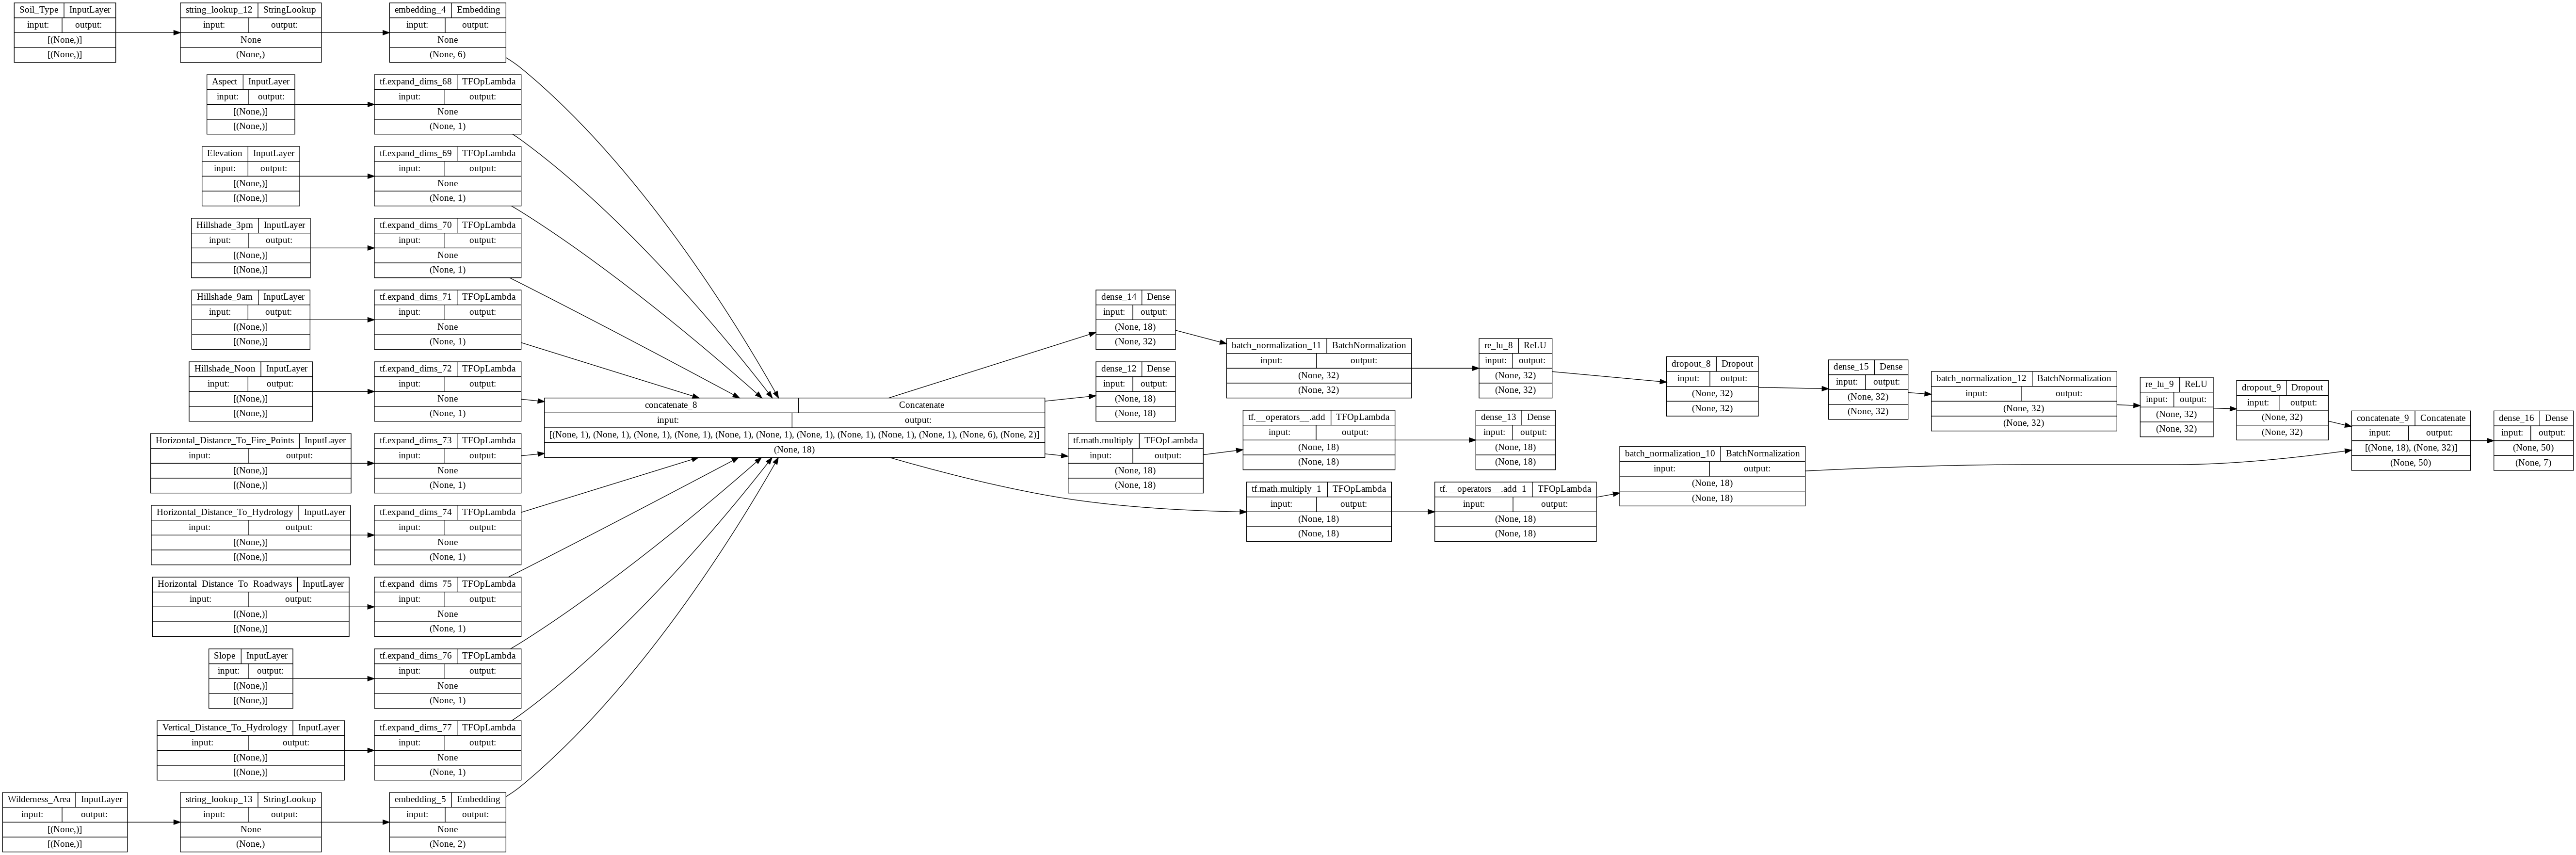

In [29]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

- **Training and Testing the model**

In [30]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 17s 8ms/step - loss: 0.6962 - sparse_categorical_accuracy: 0.7116
Epoch 2/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5885 - sparse_categorical_accuracy: 0.7452
Epoch 3/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5722 - sparse_categorical_accuracy: 0.7522
Epoch 4/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5608 - sparse_categorical_accuracy: 0.7570
Epoch 5/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5532 - sparse_categorical_accuracy: 0.7611
Epoch 6/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.7632
Epoch 7/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5423 - sparse_categorical_accuracy: 0.7654
Epoch 8/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5383 - sparse_categorical_accuracy: 0.7

## Observations from the three experiments
### Accuracy
- **Model 1 : Multi-layer feed-forward network : 74.95%**

- **Model 2 : Deep and Wide network : 79.82%**

- **Model 3 : Deep and Cross network : 80.62%**